In [1]:
from loader import Loader
from parcellation import AAL
from measures.correlation import CorrelationBasedBrainNetwork
from measures.covariance import CovarianceBasedBrainNetwork
from measures.causality import GrangerCausalityBasedBrainNetwork
from statsmodels.tsa.stattools import grangercausalitytests
from itertools import combinations
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output
import numpy as np

In [2]:
group = 'SCZ'
modality = 'BOLD'
task = 'task001_run001'
kind = 'bold_mcf_brain'

In [3]:
agent = Loader()
data = agent.filter_data(group=group, modality=modality, task=task, kind=kind)
agent = AAL(data)
parcellation_results = agent.parcellate()

In [4]:
subject, coords = parcellation_results['sub001']

In [5]:
correlation = CorrelationBasedBrainNetwork(subject, sparsify=True).generate_connectivity_matrix()

In [6]:
# causation = GrangerCausalityBasedBrainNetwork(subject, sparsify=True).generate_connectivity_matrix()

In [7]:
from graph import AssociationGraph

In [8]:
graph_obj = AssociationGraph(correlation, coords)

In [9]:
graph_obj.draw_glass_brain()

In [10]:
import persim
from ripser import ripser

In [11]:
result = ripser(correlation.values, distance_matrix=True)
diagrams = result['dgms']

In [13]:
len(diagrams)

2

In [14]:
result.keys()

dict_keys(['dgms', 'cocycles', 'num_edges', 'dperm2all', 'idx_perm', 'r_cover'])

In [15]:
def compute_betti_numbers(diagrams, dimension):
    # Count the number of features (Betti numbers) for the given dimension
    betti_numbers = sum(1 for birth, death in diagrams[dimension] if death > birth)
    return betti_numbers

betti_0 = compute_betti_numbers(diagrams, 0)  # Betti number for H0 (connected components)
betti_1 = compute_betti_numbers(diagrams, 1)  # Betti number for H1 (loops)
# betti_2 = compute_betti_numbers(diagrams, 2)  # Betti number for H2 (voids)

print(f"Betti 0: {betti_0}")
print(f"Betti 1: {betti_1}")
# print(f"Betti 2: {betti_2}")

Betti 0: 1
Betti 1: 451


In [29]:
from persim import PersLandscapeApprox, PersLandscapeExact
from persim.landscapes import plot_landscape_simple

In [ ]:
ple = PersLandscapeExact(dgms=diagrams,hom_deg=1)
ax = plot_landscape_simple(ple)

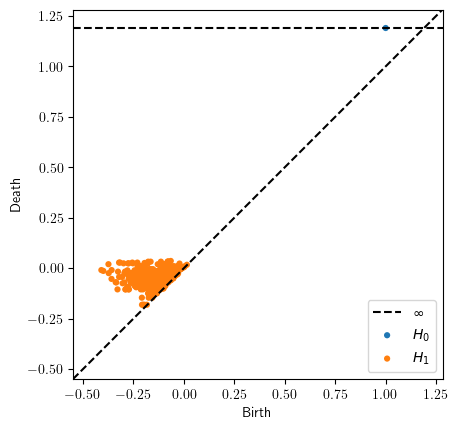

In [26]:
persim.plot_diagrams(diagrams, show=True)

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

In [18]:
G = graph_obj.create_graph()

In [15]:
graph.number_of_nodes()

116

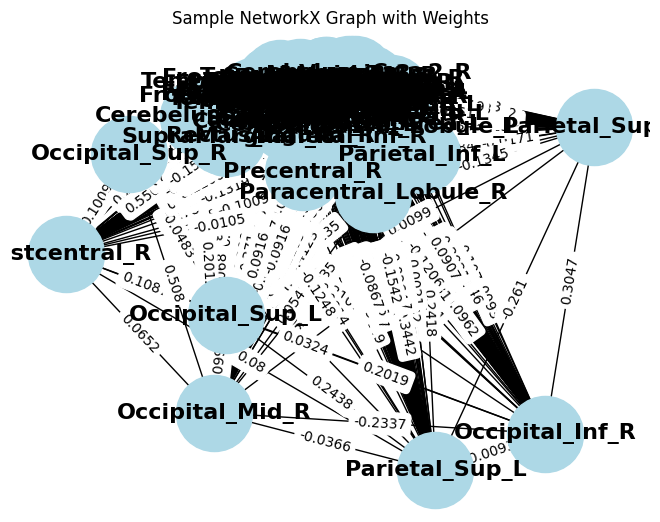

In [19]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=16, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show plot
plt.title("Sample NetworkX Graph with Weights")
plt.show()

In [ ]:
def report(test):

    test_kinds = list(test[1][0].keys())
    l = []

    for test_kind in test_kinds:
        best_results = min([(key, value) for key, value in test.items()], 
                           key=lambda x: x[1][0][test_kind][1])[1]

        stats = best_results[0][test_kind]
        ols = best_results[1]
        restricted, unrestricted = ols[0].rsquared, ols[1].rsquared

        rep = f'kind: {test_kind}, statistic: {stats[0]}, p_value: {stats[1]}'
        rep_1 = f'rest: {restricted}, unrest: {unrestricted}, diff: {restricted - unrestricted}, diff_2:{unrestricted - restricted}'
        res = rep + ' ' + rep_1
        l.append(res)

    return '<br>'.join(l)

In [ ]:
possible_combinations = random.sample(list(combinations(list(subject.columns), 2)), 20)

In [ ]:
variables = list(set([variable for pair in possible_combinations for variable in pair]))

In [ ]:
test_results = {}

In [ ]:
for combination in possible_combinations:

    test_result = grangercausalitytests(subject[list(combination)].diff().dropna(), 
                                        5, 
                                        verbose=None)
    test_results['_'.join(combination)] = test_result

    figure = make_subplots(specs=[[{"secondary_y": True}]])

    figure.add_trace(
        go.Scatter(
            x=subject.index, 
            y=subject[combination[0]].diff(),
            name=combination[0]
        ),
        secondary_y=False,
    )

    figure.add_trace(
        go.Scatter(
            x=subject.index, 
            y=subject[combination[1]].diff(),
            name=combination[1]
        ),
        secondary_y=True,
    )
    
    # figure.update_layout(title=report(test_result))
    figure.add_annotation(text=report(test_result), 
                    align='left',
                    showarrow=False,
                    xref='paper',
                    yref='paper',
                    x=1.1,
                    y=0.8,
                    bordercolor='black',
                    borderwidth=1)

    figure.write_html(f'figures\\{"_".join(combination)}.html', auto_open=False)

# clear_output()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3017  , p=0.5837  , df_denom=132, df_num=1
ssr based chi2 test:   chi2=0.3086  , p=0.5786  , df=1
likelihood ratio test: chi2=0.3082  , p=0.5788  , df=1
parameter F test:         F=0.3017  , p=0.5837  , df_denom=132, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3552  , p=0.7017  , df_denom=129, df_num=2
ssr based chi2 test:   chi2=0.7380  , p=0.6914  , df=2
likelihood ratio test: chi2=0.7360  , p=0.6921  , df=2
parameter F test:         F=0.3552  , p=0.7017  , df_denom=129, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1587  , p=0.9239  , df_denom=126, df_num=3
ssr based chi2 test:   chi2=0.5024  , p=0.9184  , df=3
likelihood ratio test: chi2=0.5015  , p=0.9186  , df=3
parameter F test:         F=0.1587  , p=0.9239  , df_denom=126, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6194  , p=0.6495  

In [ ]:
findings = []

In [ ]:
for key , value in test_results.items():
    value = [item[1][0] for item in value.items()]
    p_value = [item['ssr_ftest'][1] for item in value]

    if any([p < 0.05 for p in p_value]):
        findings.append(key)

In [ ]:
findings

['Heschl_R_Cerebelum_Crus2_R',
 'Frontal_Sup_Medial_R_Hippocampus_L',
 'Insula_L_Hippocampus_L',
 'Frontal_Mid_R_Temporal_Sup_R',
 'Frontal_Sup_Orb_L_Frontal_Inf_Orb_R',
 'Frontal_Sup_Orb_R_Vermis_3',
 'Rolandic_Oper_R_Fusiform_L',
 'Frontal_Med_Orb_R_Postcentral_L',
 'Fusiform_L_Cerebelum_Crus1_R']

In [ ]:
from pprint import pprint

In [ ]:
for finding in findings:
    pprint(test_results[finding])
    input("Press Enter to continue...")
    clear_output()

In [12]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries, significance_level=0.05):
    adf_test = adfuller(timeseries)
    p_value = adf_test[1]
    return adf_test

In [ ]:
for var in variables:
    is_stationary = check_stationarity(subject[var].diff().dropna())
    if is_stationary[1] > 0.05:
        print(f"{var} is NOT stationary")

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
from scipy import stats

In [21]:
def acf_look_back_period(series, n_lags):
    acf_, confidence_interval = acf(series, nlags=n_lags, alpha=0.05)
    centered_ci = confidence_interval - acf_[:, None]
    outside = np.abs(acf_) >= centered_ci[:, 1]
    return np.argmax(~outside)

In [22]:
acf_look_back_period(subject['Hippocampus_R'], 137 // 2)

3

In [13]:
is_stationary = check_stationarity(subject.diff().dropna())

ValueError: x is required to have ndim 1 but has ndim 2

In [ ]:
is_stationary[1] < 0.05

True

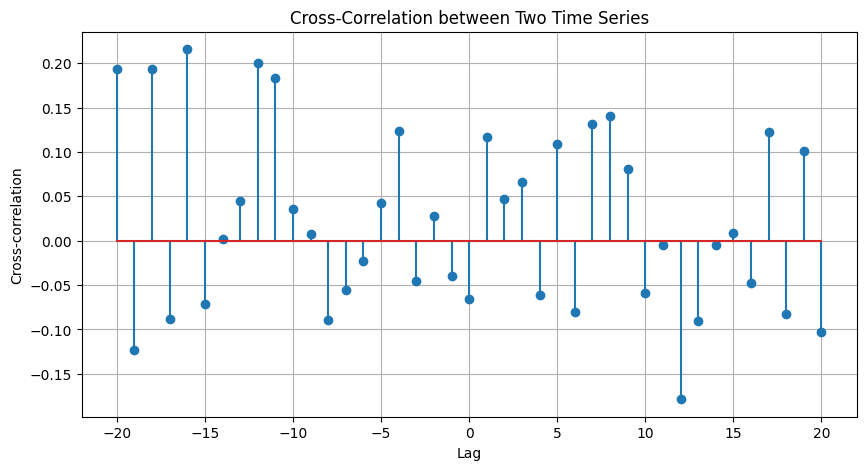

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data (replace with your actual time series data)
np.random.seed(0)
time_series_1 = np.random.rand(100)
time_series_2 = np.random.rand(100)

# Function to compute cross-correlation
def cross_correlation(x, y, lag_max):
    lags = np.arange(-lag_max, lag_max + 1)
    corr = [np.corrcoef(x, np.roll(y, lag))[0, 1] for lag in lags]
    return lags, corr

# Parameters
lag_max = 20

# Compute cross-correlation
lags, corr = cross_correlation(time_series_1, time_series_2, lag_max)

# Plot cross-correlation
plt.figure(figsize=(10, 5))
plt.stem(lags, corr)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-Correlation between Two Time Series')
plt.grid()
plt.show()

Significant lag: None


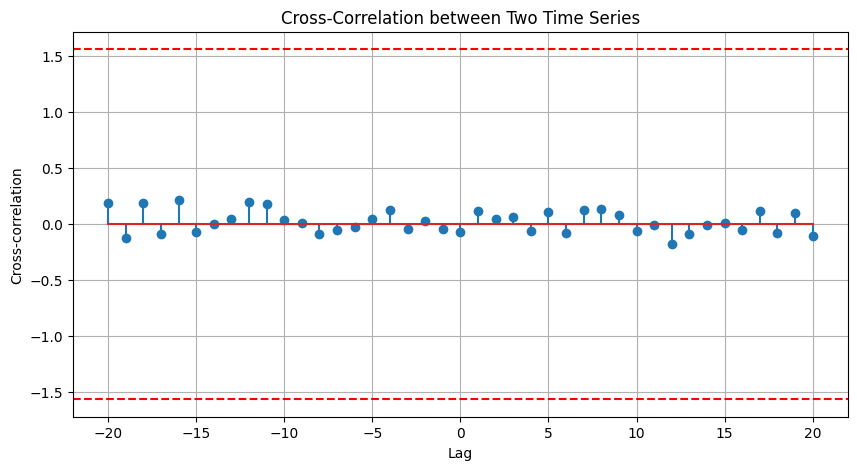

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Function to compute cross-correlation
def cross_correlation(x, y, lag_max):
    lags = np.arange(-lag_max, lag_max + 1)
    corr = [np.corrcoef(x, np.roll(y, lag))[0, 1] for lag in lags]
    return lags, corr

# Function to compute significant lag of the cross-correlation
def significant_cross_correlation_lag(x, y, lag_max, alpha=0.05):
    lags, corr = cross_correlation(x, y, lag_max)
    
    # Compute confidence intervals using Bartlett's formula
    n = len(x)
    se = 1.0 / np.sqrt(n)
    confidence_interval = se * np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((y - np.mean(y))**2))
    
    centered_ci = np.array([-1.96, 1.96]) * confidence_interval  # 95% confidence interval
    
    outside = np.abs(corr) >= centered_ci[1]
    if np.any(outside):
        significant_lag = lags[np.argmax(outside)]
    else:
        significant_lag = None
    
    return significant_lag, lags, corr, centered_ci


significant_lag, lags, corr, centered_ci = significant_cross_correlation_lag(time_series_1, time_series_2, lag_max)

# Print significant lag
print(f"Significant lag: {significant_lag}")

# Plot cross-correlation
plt.figure(figsize=(10, 5))
plt.stem(lags, corr)
plt.axhline(y=centered_ci[0], color='r', linestyle='--')
plt.axhline(y=centered_ci[1], color='r', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.title('Cross-Correlation between Two Time Series')
plt.grid()
plt.show()


In [ ]:
from models import GrangerCausality

In [ ]:
agent = GrangerCausality(subject[variables])

In [ ]:
results = agent.fit()

p-values cannot be calculated for the regression coefficients in Granger causality model becausethe rank of the data matrix is too low (127). Try increasing the number of samples.
p-values cannot be calculated for the regression coefficients in Granger causality model becausethe rank of the data matrix is too low (127). Try increasing the number of samples.
p-values cannot be calculated for the regression coefficients in Granger causality model becausethe rank of the data matrix is too low (127). Try increasing the number of samples.
p-values cannot be calculated for the regression coefficients in Granger causality model becausethe rank of the data matrix is too low (127). Try increasing the number of samples.
p-values cannot be calculated for the regression coefficients in Granger causality model becausethe rank of the data matrix is too low (127). Try increasing the number of samples.
p-values cannot be calculated for the regression coefficients in Granger causality model becausethe 

[02:12:44] Time taken: 29.59s                                                                         ]8;id=672819;file://c:\Users\Wallex\projects\fMRI\models\granger.py\granger.py]8;;\:]8;id=717449;file://c:\Users\Wallex\projects\fMRI\models\granger.py#50\50]8;;\
                                                                                                                   

In [ ]:
results

{'Angular_L': [],
 'Vermis_1_2': [],
 'Occipital_Mid_R': [],
 'Cerebelum_9_L': [],
 'ParaHippocampal_R': [],
 'Frontal_Sup_R': [],
 'SupraMarginal_L': [],
 'Cerebelum_Crus1_L': [],
 'Hippocampus_R': [],
 'Frontal_Inf_Tri_R': [],
 'Fusiform_L': [],
 'Cerebelum_7b_R': [],
 'Cerebelum_3_R': [],
 'Frontal_Sup_L': [],
 'Frontal_Mid_R': [],
 'Vermis_4_5': [],
 'Frontal_Inf_Oper_R': [],
 'Parietal_Sup_L': [],
 'Occipital_Sup_R': [],
 'Frontal_Med_Orb_R': [],
 'Frontal_Sup_Medial_R': [],
 'Frontal_Inf_Orb_R': [],
 'Lingual_L': [],
 'Pallidum_L': [],
 'Postcentral_R': [],
 'Vermis_9': [],
 'Frontal_Inf_Oper_L': [],
 'Cerebelum_9_R': [],
 'Cuneus_L': [],
 'Occipital_Mid_L': [],
 'Cerebelum_6_L': [],
 'Amygdala_L': [],
 'Cerebelum_8_R': [],
 'Amygdala_R': [],
 'Calcarine_R': []}